In [1]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# load data
train_dir = "/kaggle/input/poultry/data_split/train/"
test_dir = "/kaggle/input/poultry/data_split/test/"
val_dir = "/kaggle/input/poultry/data_split/val/"

In [ ]:
# model parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 3

In [ ]:
# Data Augmentation for Training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.4,
    fill_mode='nearest'
)

# data aug for val and test set
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# load and configure datagens
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

In [ ]:
# define model
def create_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    # freeze the basse layers of pretrained-model
    base_model.trainable = False

    # create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# create model summary
model = create_model()
model.summary()

In [ ]:
# training callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('pdisease_detector.keras', verbose=1)
]

# calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

In [ ]:
# plot graphs
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12,8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')

    # save figures
    plt.savefig('poultry_disease_dectector_training_history.png')

    plt.show() # show plot

In [ ]:
plot_training_history(history)

In [ ]:
# evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [6]:
# predict an image
IMG_HEIGHT = 224
IMG_WIDTH = 224
class_names = ['coccidiosis', 'healthy', 'newcastle']

def predict_image(img_path):
    model_path = "/kaggle/input/poultry_detector/keras/default/1/pdisease_detector.keras"
    model = tf.keras.models.load_model(model_path)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")

    # show all class probabilities
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]:.4f}")

    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: healthy
Confidence: 0.9981
coccidiosis: 0.0004
healthy: 0.9981
newcastle: 0.0016


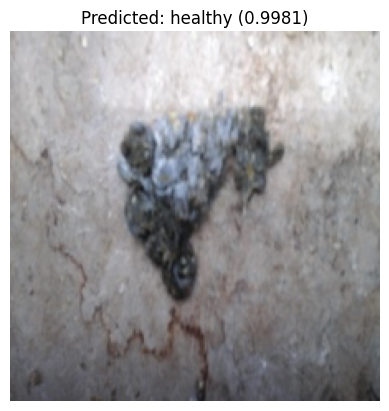

In [18]:

predict_image('/kaggle/input/disease-images/healthy16.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: coccidiosis
Confidence: 0.9996
coccidiosis: 0.9996
healthy: 0.0003
newcastle: 0.0001


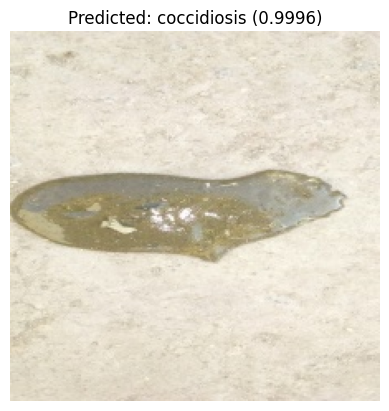

In [17]:
predict_image('/kaggle/input/disease-images/cocci50.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: newcastle
Confidence: 0.5724
coccidiosis: 0.4139
healthy: 0.0137
newcastle: 0.5724


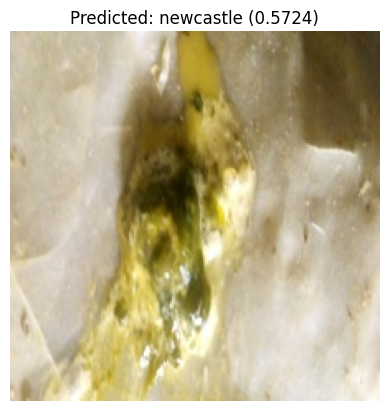

In [16]:
predict_image('/kaggle/input/disease-images/ncd40.jpg')